In [1]:
# !pip install --user package_name
import csv
import time
import pandas as pd
import string

import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

import re
from collections import Counter
from string import punctuation
from nltk.corpus import stopwords
from wordcloud import WordCloud 

from textblob import TextBlob

import folium

In [2]:
col_names=['date','user','text','likes','retweets']

df = pd.read_csv('modi_data_200k.csv', names=col_names)

df.head()
#df.count()

,date,user,text,likes,retweets
0,2019-03-31 17:59:57,AbhisheK738233,NIRAV MODI STATEMENT IN LONDON COURT \n\nI was...,0,0
1,2019-03-31 17:59:48,siddhhaarth_,@RameenPrince @AzmiShabana @kanhaiyakumar Have...,0,0
2,2019-03-31 17:59:45,63dc525108ce4bb,@PrathapJMR @VishnuReddyBJP @SakshiHDTV @ncbn ...,1,0
3,2019-03-31 17:59:41,Modi_warrior,@ndtv Did you cover her interaction forum wher...,0,0
4,2019-03-31 17:59:41,rchandan27,Subramanian Swamy Interview: Economically We H...,0,0


In [3]:
# Sort dataframe by date column
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date',ascending=True)
df = df.reset_index().drop('index',axis=1)
df.head()

,date,user,text,likes,retweets
0,2019-03-25 05:52:57,sri9011,"""When Modi promised “minimum government, maxim...",2,2
1,2019-03-25 05:52:58,AshwiniBN4,@republic Talk all the nonsense and continue a...,1,0
2,2019-03-25 05:52:58,callvrao,@ExSecular @commandersaini What did he just sa...,1,0
3,2019-03-25 05:53:04,whoskj2,By asking his supporters to prefix chowkidar t...,2,0
4,2019-03-25 05:53:07,Suchindranath,My answer to Who among these is the most power...,1,1


In [4]:
df.shape

(199990, 5)

In [5]:
df = df.drop_duplicates('text')
df.shape

(191484, 5)

## Data Analysis

In [6]:
#extract the tweet with more FAVs and more RTs:

fav_max = np.max(df['likes'])
rt_max = np.max(df['retweets'])

fav = df[df.likes == fav_max].index[0]
rt = df[df.retweets == rt_max].index[0]

# Max FAVs:
print("\nThe tweet with more likes is: \n{}".format(df['text'][fav]))
print("Number of likes: {}".format(fav_max))
#print("{} characters.\n".format(data['len'][fav]))

# Max RTs:
print("\nThe tweet with more retweets is: \n{}".format(df['text'][rt]))
print("Number of retweets: {}".format(rt_max))
#print("{} characters.\n".format(data['len'][rt]))


The tweet with more likes is: 
Congress led UPA
Surgical Strike : Don't do it
Air Strike: Don't do it
A-SAT Missile: Don't do it

Modi Sarkar
Surgical Strike: Go For It
Air Strike: Go For It
A-SAT Missile: Go For It

Modi Hai To Mumkin Hai. #MissionShakti
Number of likes: 43433

The tweet with more retweets is: 
Congress led UPA
Surgical Strike : Don't do it
Air Strike: Don't do it
A-SAT Missile: Don't do it

Modi Sarkar
Surgical Strike: Go For It
Air Strike: Go For It
A-SAT Missile: Go For It

Modi Hai To Mumkin Hai. #MissionShakti
Number of retweets: 13829


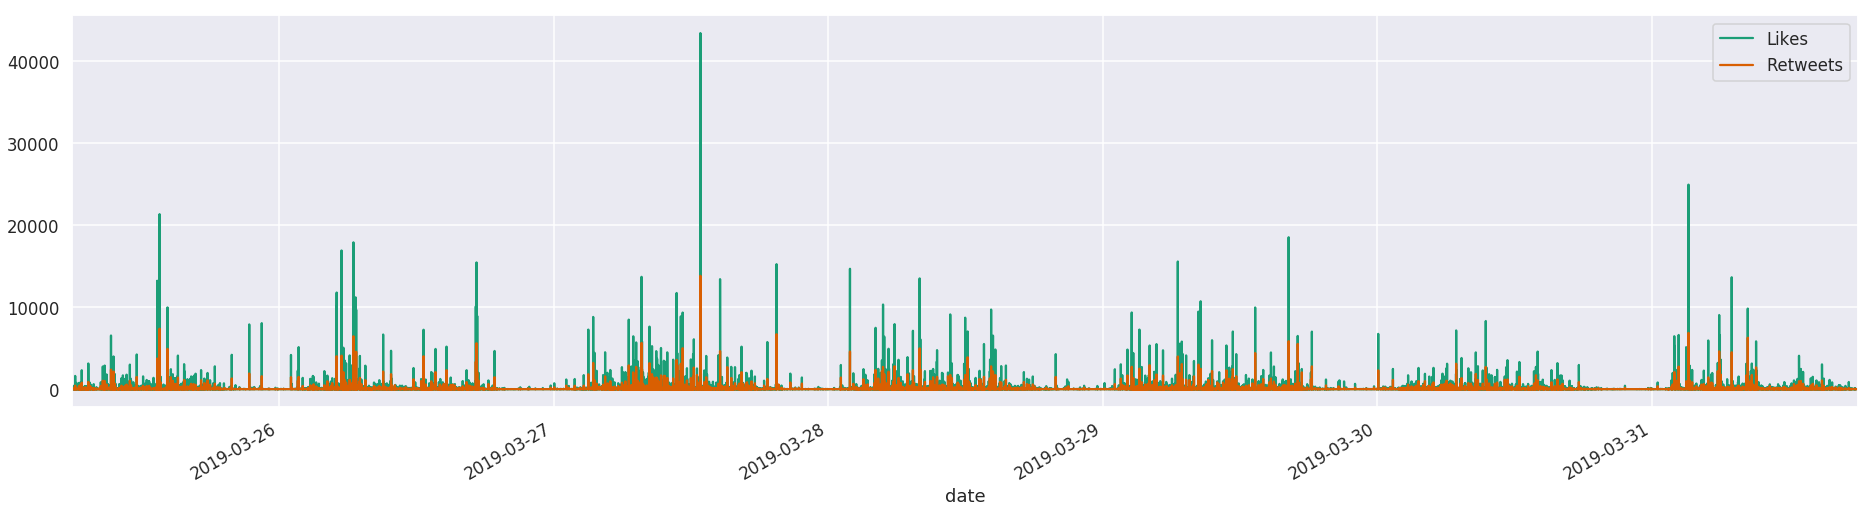

In [7]:
# Create time series for the data:

#tlen = pd.Series(data=data['len'].values, index=data['Date'])
tfav = pd.Series(data=df['likes'].values, index=df['date'])
tret = pd.Series(data=df['retweets'].values, index=df['date'])

# Likes vs retweets visualization:
tfav.plot(figsize=(32,8), label="Likes", legend=True)
tret.plot(figsize=(32,8), label="Retweets", legend=True)

In [6]:
#function to extract hashtags from every tweet
def hashtag_extract(tweets):
    hashtags = []
    # Loop over the words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)

    return hashtags

In [7]:
HT_regular = hashtag_extract(df['text'])

# unnesting list
HT_unnested = sum(HT_regular,[])

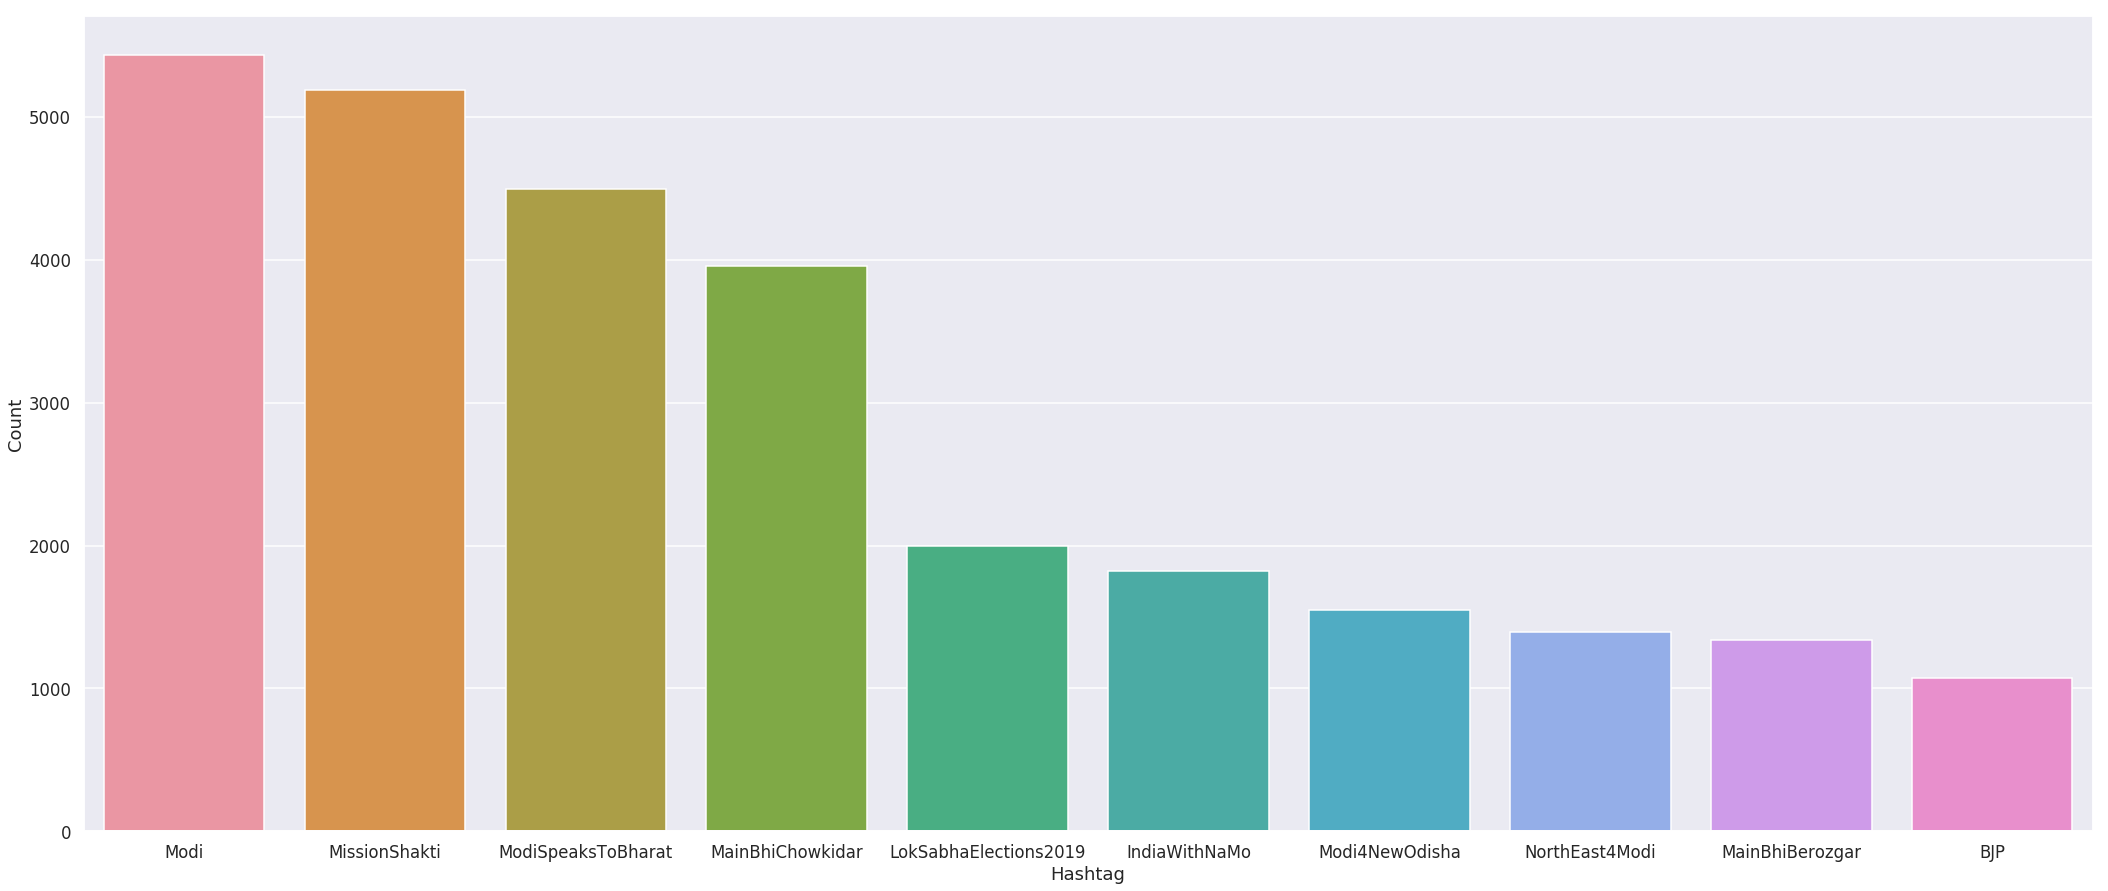

In [12]:
a = nltk.FreqDist(HT_unnested)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(36,15))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [13]:
df['likes'].corr(df['retweets'])

0.9639484930965402

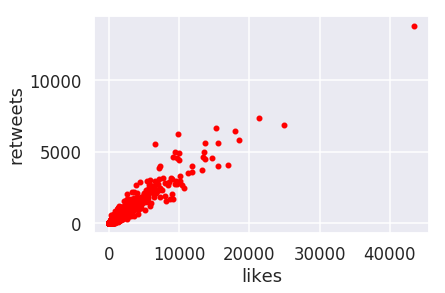

In [14]:
df.plot.scatter(x='likes',y='retweets',c='r')

## Data Cleaning

In [16]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uffff') 
    return tweet
#
#df1 = df.loc['0':'5', 'text': ]
df['clean_text'] = df['text'].apply(processTweet)
df.head()

,date,user,text,likes,retweets,clean_text
0,2019-03-25 05:52:57,sri9011,"""When Modi promised “minimum government, maxim...",2,2,when modi promised “minimum government maximum...
1,2019-03-25 05:52:58,AshwiniBN4,@republic Talk all the nonsense and continue a...,1,0,talk all the nonsense and continue all the dra...
2,2019-03-25 05:52:58,callvrao,@ExSecular @commandersaini What did he just sa...,1,0,what did just say vote for modi welcome bjp t...
3,2019-03-25 05:53:04,whoskj2,By asking his supporters to prefix chowkidar t...,2,0,asking his supporters prefix chowkidar their n...
4,2019-03-25 05:53:07,Suchindranath,My answer to Who among these is the most power...,1,1,answer who among these the most powerful world...


In [17]:
# drop duplicates
df = df.drop_duplicates('clean_text')
df.shape

(162973, 6)

## Sentiment Categorizing

In [18]:
def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

df['category'] = df['clean_text'].apply(analyze_sentiment)
df.head()

/home/cadbury/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,date,user,text,likes,retweets,clean_text,category
0,2019-03-25 05:52:57,sri9011,"""When Modi promised “minimum government, maxim...",2,2,when modi promised “minimum government maximum...,-1
1,2019-03-25 05:52:58,AshwiniBN4,@republic Talk all the nonsense and continue a...,1,0,talk all the nonsense and continue all the dra...,0
2,2019-03-25 05:52:58,callvrao,@ExSecular @commandersaini What did he just sa...,1,0,what did just say vote for modi welcome bjp t...,1
3,2019-03-25 05:53:04,whoskj2,By asking his supporters to prefix chowkidar t...,2,0,asking his supporters prefix chowkidar their n...,1
4,2019-03-25 05:53:07,Suchindranath,My answer to Who among these is the most power...,1,1,answer who among these the most powerful world...,1


## Visualization of Sentiment

In [30]:
# check the number of positive vs. negative tagged sentences
positives = df['category'][df.category == 1]
negatives = df['category'][df.category == -1]
neutrals = df['category'][df.category == 0]


print('number of positve categorized text is:  {}'.format(len(positives)))
print('number of negative categorized text is: {}'.format(len(negatives)))
print('number of neutral categorized text is: {}'.format(len(neutrals)))
print('total length of the data is:            {}'.format(df.shape[0]))

number of positve categorized sentences is:  72250
number of negative categorized sentences is: 35510
number of neutral categorized sentences is: 55213
total length of the data is:            162973


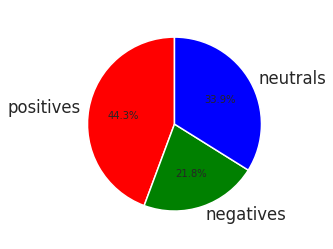

In [31]:
#import matplotlib.pyplot as plt

slices_len = [len(positives), len(negatives), len(neutrals)]
category = ['positives', 'negatives', 'neutrals']
colors = ['r', 'g', 'b']

plt.pie(slices_len, labels=category, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

## Data Visualization

In [10]:
# tokenize helper function
import string
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

def remove_words(word_list):
    remove = ['narendra','modi','...','“','”','’','…','modi’']
    return [w for w in word_list if w not in remove]
# -------------------------------------------
# tokenize message column and create a column for tokens
df = df.copy()
df['tokens'] = df['clean_text'].apply(text_process) # tokenize style 1
df['no_modi'] = df['tokens'].apply(remove_words) #tokenize style 2
df = df.drop(['tokens'],axis=1)
df.head()

,date,user,text,likes,retweets,clean_text,category,no_modi
0,2019-03-25 05:52:57,sri9011,"""When Modi promised “minimum government, maxim...",2,2,when modi promised “minimum government maximum...,-1,"[promised, “minimum, government, maximum, gove..."
1,2019-03-25 05:52:58,AshwiniBN4,@republic Talk all the nonsense and continue a...,1,0,talk all the nonsense and continue all the dra...,0,"[talk, nonsense, continue, drama, vote]"
2,2019-03-25 05:52:58,callvrao,@ExSecular @commandersaini What did he just sa...,1,0,what did just say vote for modi welcome bjp t...,1,"[say, vote, welcome, bjp, told, rahul, main, c..."
3,2019-03-25 05:53:04,whoskj2,By asking his supporters to prefix chowkidar t...,2,0,asking his supporters prefix chowkidar their n...,1,"[asking, supporters, prefix, chowkidar, names,..."
4,2019-03-25 05:53:07,Suchindranath,My answer to Who among these is the most power...,1,1,answer who among these the most powerful world...,1,"[answer, among, powerful, world, leader, today..."


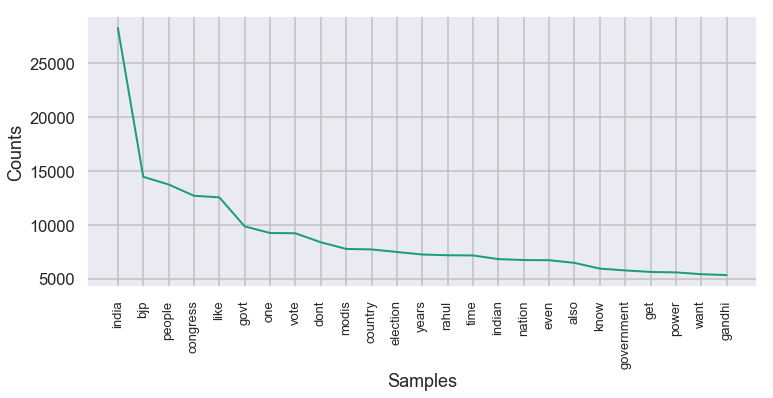

Text(0.5, 0, 'Word Rank')

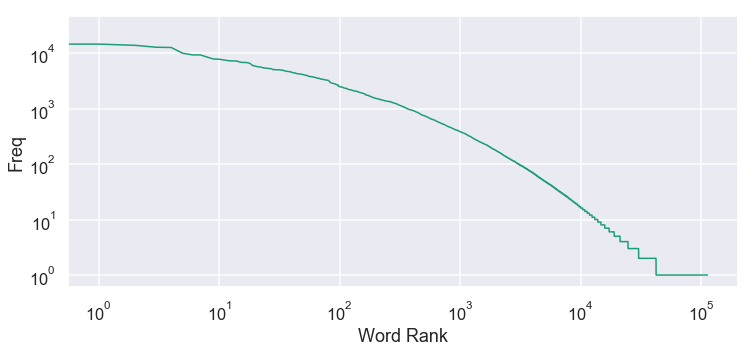

In [11]:
# plot word frequency distribution of first few words without narendra, modi
# no_modi
no_modi = []
for ls in df['no_modi']:
    words = [w for w in ls]
    for word in words:
        no_modi.append(word)
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(no_modi)
fd.plot(25,cumulative=False)

# log-log  of all words -- no_modi 
word_counts = sorted(Counter(no_modi).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

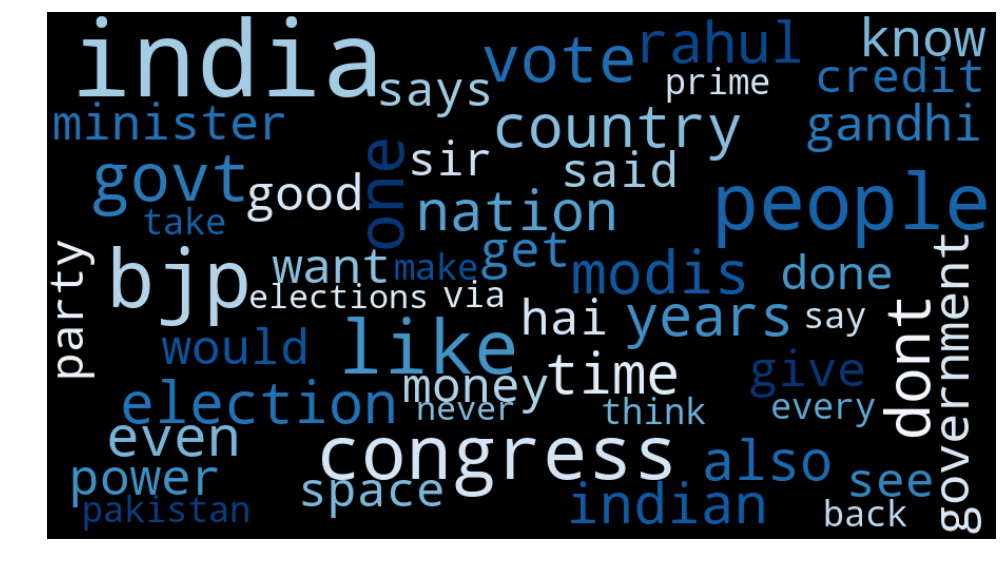

In [12]:
# split sentences to get individual words
all_words = []

for line in df['no_modi']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=50,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# split sentences to get individual words
all_pos_words = []
df_modi_pos = df[df.category==1]
for line in df_modi_pos['no_modi']: # try 'tokens'
    all_pos_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_pos_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=50,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Greens',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# split sentences to get individual words
all_neg_words = []
df_modi_neg = df[df.category==-1]
#df_modi_neg.head()
for line in df_modi_neg['no_modi']: # try 'tokens'
    all_neg_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_neg_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=50,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Reds',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Cleaned data 

In [13]:
dataset = df.filter(['clean_text','category'], axis=1)
dataset.shape

(162973, 2)

In [14]:
dataset.to_csv('dataset.csv', index = False, sep=",", encoding="utf-8")

### Visualization of  Geo Spacial data

In [31]:
col_names=['bbox_cord','city','country']

df_geo = pd.read_csv('modi_geo_data.csv', names=col_names)

df_geo.head()

,bbox_cord,city,country
0,"[[[80.397161, 16.283456], [80.843816, 16.28345...","Vijayawada, India",India
1,"[[[82.671054, 25.166781], [83.194857, 25.16678...","Varanasi, India",India
2,"[[[76.84252, 28.397657], [77.347652, 28.397657...","New Delhi, India",India
3,"[[[73.6246953, 18.2801029], [74.1954594, 18.28...","Haveli, India",India
4,"[[[79.380325, 28.959342], [79.422686, 28.95934...","Rudrapur, India",India


In [32]:
df_geo.shape
#df_geo = df_geo.drop_duplicates()

(8317, 3)

In [33]:
import numpy as np
import json
def geo_mean(x):
    y = json.loads(x)
    y = np.asarray(y)
    mean_geoloc = np.add(np.add((y[:][0][0]),(y[:][0][1]))/2,\
                         (np.add((y[:][0][2]),(y[:][0][3]))/2))/2    
    return np.around(mean_geoloc,decimals=6)

# append new column  and clean up df
df_geo['geo_code'] = df_geo['bbox_cord'].apply(geo_mean)
df_geo = df_geo.drop(['bbox_cord'],axis=1)
df_geo.head()

,city,country,geo_code
0,"Vijayawada, India",India,"[80.620488, 16.610865]"
1,"Varanasi, India",India,"[82.932955, 25.373376]"
2,"New Delhi, India",India,"[77.095086, 28.63849]"
3,"Haveli, India",India,"[73.910077, 18.508161]"
4,"Rudrapur, India",India,"[79.401506, 28.974728]"


In [35]:

# get latitudes and longitudes

# some helper funtions to get longs and lats
def lats(x):
    return x[1]

def longs(x):
    return x[0]

# --------------------------------------------------------#
# append longs and lats to dframe
df_geo ['latitude'] = df_geo ['geo_code'].apply(lats)
df_geo ['longitude'] = df_geo ['geo_code'].apply(longs)
df_geo.head()

,city,country,geo_code,latitude,longitude
0,"Vijayawada, India",India,"[80.620488, 16.610865]",16.610865,80.620488
1,"Varanasi, India",India,"[82.932955, 25.373376]",25.373376,82.932955
2,"New Delhi, India",India,"[77.095086, 28.63849]",28.638490,77.095086
3,"Haveli, India",India,"[73.910077, 18.508161]",18.508161,73.910077
4,"Rudrapur, India",India,"[79.401506, 28.974728]",28.974728,79.401506


In [36]:
from IPython.display import IFrame
from folium import plugins

# use the folium library to create all tweet origins in the dataset on map of India
#df_india = df_geo[df_geo.country=='India']
geoplots = []

for index, row in df_geo[['latitude','longitude']].iterrows():
    geoplots.append([row['latitude'],row['longitude']])
mus = folium.Map(location=[39, -99], zoom_start=4)

plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(mus)

mus.choropleth(
    geo_data='india_states.geojson',
    fill_color='blue', 
    fill_opacity=0.1, 
    line_opacity=0.2,
    name='india_states')
    
mus.add_child(plugins.HeatMap(geoplots,
                            name='Twitter HeatMap',
                            radius=10,
                            max_zoom=1,
                            blur=10, 
                            max_val=3.0))

folium.TileLayer('cartodbpositron').add_to(mus)
folium.TileLayer('cartodbdark_matter').add_to(mus)
folium.TileLayer('Mapbox Control Room').add_to(mus)
folium.LayerControl().add_to(mus)
mus.save("twitter_india_map.html") 
IFrame('twitter_india_map.html', width=960, height=520)